In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from IPython import display
import math
from sklearn.preprocessing import StandardScaler

In [2]:
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Multi_core/dataset_p.csv')
# data = pd.read_csv('../data/prepocessed_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dropped_col = ['p']

In [5]:
data.head()

,L1-dcache-load-misses,time,dTLB-loads,cpu-used,branch-load-misses,p
0,35340541,0.170,1474918765,1.331,15884552,0.15
1,35716092,0.096,1298296555,1.195,15376675,0.15
2,30699263,0.072,1440048177,1.392,16049791,0.15
3,33251076,0.060,1355002190,1.282,15515069,0.15
4,30187700,0.053,1404179600,1.434,17236526,0.15


In [6]:
X = data.drop(dropped_col, axis=1)
y = data[dropped_col]

In [7]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [8]:
# train test split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [9]:
X_train_tensor = torch.from_numpy(X_train.values)
y_train_tensor = torch.from_numpy(y_train.values)
X_val_tensor = torch.from_numpy(X_val.values)
y_val_tensor = torch.from_numpy(y_val.values)
X_test_tensor = torch.from_numpy(X_test.values)
y_test_tensor = torch.from_numpy(y_test.values)

In [10]:
print("X_train_Size: " + str(X_train_tensor.shape))
print("y_train_Size: " + str(y_train_tensor.shape))
print("X_val_Size: " + str(X_val_tensor.shape))
print("y_val_Size: " + str(y_val_tensor.shape))
print("X_test: " + str(X_test_tensor.shape))
print("y_test_Size: " + str(y_test_tensor.shape))

X_train_Size: torch.Size([6804, 5])
y_train_Size: torch.Size([6804, 1])
X_val_Size: torch.Size([1458, 5])
y_val_Size: torch.Size([1458, 1])
X_test: torch.Size([1459, 5])
y_test_Size: torch.Size([1459, 1])


In [11]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
I = 5  # input feature
O = 1 # output result
H = 128 # hidden unit

In [13]:
model = nn.Sequential(
    nn.Linear(I, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, O)
)
model = model.to(torch.float64)

In [14]:
weight_tensor = model[0].weight

# Get the datatype of the weight tensor
weight_tensor.dtype

torch.float64

In [15]:
X_train_tensor.dtype

torch.float64

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train(model, loader, optimizer):
    loss_sum = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        optimizer.zero_grad()
        output = model(inputs)
        loss = torch.nn.functional.mse_loss(output, targets)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        
    avg_loss = loss_sum / len(loader)
    print(f"Train MSE loss: {avg_loss:.4f}")
    return avg_loss

In [18]:
train_losses = []
train_rmses = []
train_maes = []
val_losses = []
val_rmses = []
val_maes = []

In [19]:
#train
for epoch in range(500):
    print(f"Epoch {epoch + 1}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    with torch.no_grad():
        mae_sum = 0.0
        rmse_sum = 0.0
        total = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            output = model(inputs)
            mae_sum += torch.abs(output - targets).sum().item()
            rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)
        mae = mae_sum / total
        rmse = math.sqrt(rmse_sum / total)
        train_rmses.append(rmse)
        train_maes.append(mae)
        print(f"Train MSE: {train_loss:.4f}, Train MAE: {mae:.4f}, Train RMSE: {rmse:.4f}")
    
    # validation
    with torch.no_grad():
        loss_sum = 0.0
        val_mae_sum = 0.0
        val_rmse_sum = 0.0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            output = model(inputs)
            loss = torch.nn.functional.mse_loss(output, targets)
            loss_sum += loss.item()
            val_mae_sum += torch.abs(output - targets).sum().item()
            val_rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)

        avg_loss = loss_sum / len(test_loader)
        val_losses.append(avg_loss)
        val_mae = val_mae_sum / total
        val_rmse = math.sqrt(val_rmse_sum / total)
        val_rmses.append(val_rmse)
        val_maes.append(val_mae)
        print(f"Test MSE: {avg_loss:.4f}, Test MAE: {val_mae:.4f}, Test RMSE: {val_rmse:.4f}")
    # display.clear_output(wait=True)

Epoch 1
Train MSE loss: 4.0590
Train MSE: 4.0590, Train MAE: 0.5329, Train RMSE: 0.8268
Test MSE: 0.7178, Test MAE: 0.5462, Test RMSE: 0.8452
Epoch 2
Train MSE loss: 0.5235
Train MSE: 0.5235, Train MAE: 0.4662, Train RMSE: 0.6972
Test MSE: 0.4977, Test MAE: 0.4673, Test RMSE: 0.7037
Epoch 3
Train MSE loss: 0.3749
Train MSE: 0.3749, Train MAE: 0.3295, Train RMSE: 0.5214
Test MSE: 0.3069, Test MAE: 0.3521, Test RMSE: 0.5541
Epoch 4
Train MSE loss: 0.3161
Train MSE: 0.3161, Train MAE: 0.3612, Train RMSE: 0.5126
Test MSE: 0.2797, Test MAE: 0.3686, Test RMSE: 0.5258
Epoch 5
Train MSE loss: 0.2662
Train MSE: 0.2662, Train MAE: 0.4290, Train RMSE: 0.6429
Test MSE: 0.4661, Test MAE: 0.4536, Test RMSE: 0.6850
Epoch 6
Train MSE loss: 0.2272
Train MSE: 0.2272, Train MAE: 0.3717, Train RMSE: 0.5533
Test MSE: 0.3097, Test MAE: 0.3759, Test RMSE: 0.5570
Epoch 7
Train MSE loss: 0.2437
Train MSE: 0.2437, Train MAE: 0.2759, Train RMSE: 0.4192
Test MSE: 0.1930, Test MAE: 0.2893, Test RMSE: 0.4366
Epoch 

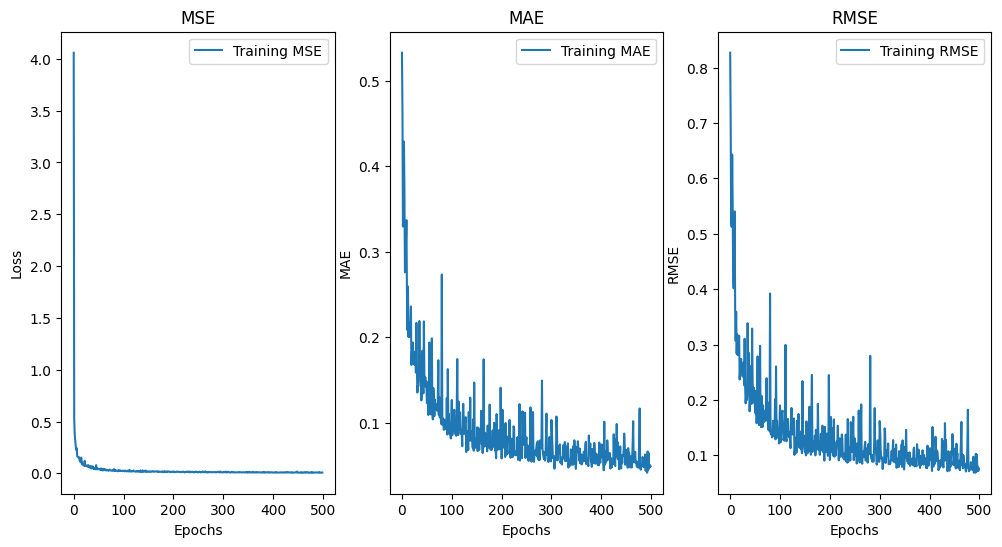

In [20]:
# train loss, mae, rmse
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(train_losses, label='Training MSE')
ax1.set_title('MSE')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(train_maes, label='Training MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(train_rmses, label='Training RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()

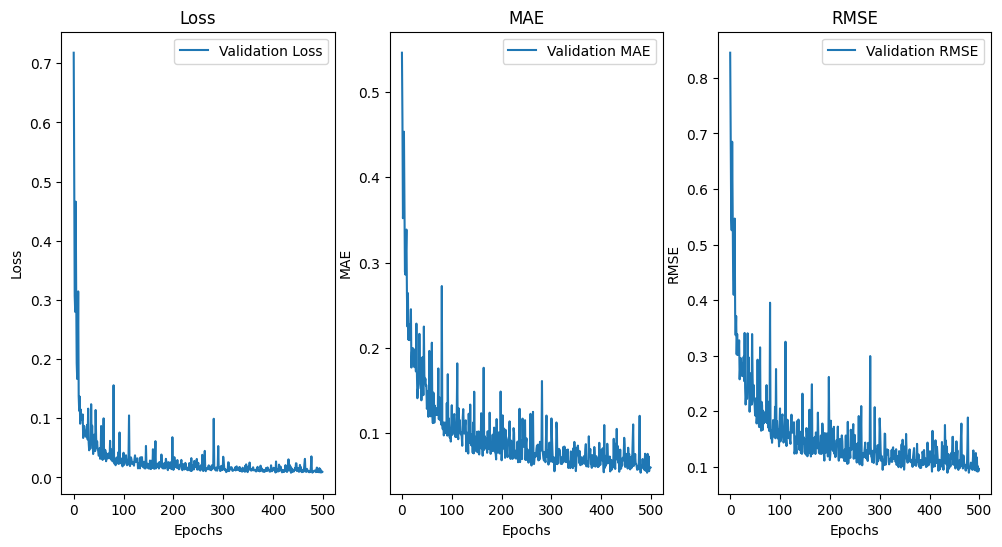

In [21]:
# val loss, accuracy
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(val_maes, label='Validation MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(val_rmses, label='Validation RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()

In [22]:
with torch.no_grad():
      loss_sum = 0.0
      val_mae_sum = 0.0
      val_rmse_sum = 0.0
      total = 0
      for batch_idx, (inputs, targets) in enumerate(test_loader):
          output = model(inputs)
          loss = torch.nn.functional.mse_loss(output, targets)
          loss_sum += loss.item()
          val_mae_sum += torch.abs(output - targets).sum().item()
          val_rmse_sum += torch.square(output - targets).sum().item()
          total += len(targets)

      avg_loss = loss_sum / len(test_loader)
      val_losses.append(avg_loss)
      val_mae = val_mae_sum / total
      val_rmse = math.sqrt(val_rmse_sum / total)
      val_rmses.append(val_rmse)
      val_maes.append(val_mae)
      print(f"Test MSE: {avg_loss:.4f}, Test MAE: {val_mae:.4f}, Test RMSE: {val_rmse:.4f}")

Test MSE: 0.0102, Test MAE: 0.0612, Test RMSE: 0.1014


In [23]:
with torch.no_grad():
  y_pred = model(X_test_tensor).detach().numpy()

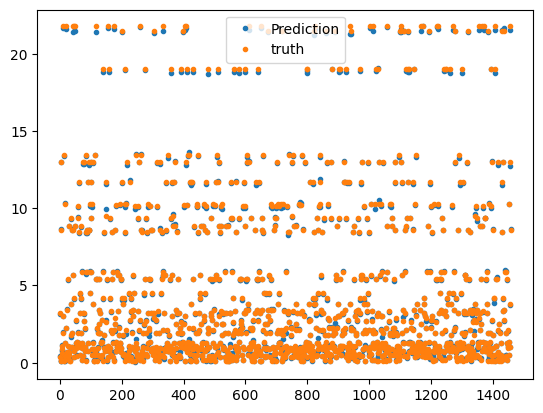

In [24]:
plt.plot(np.array([i for i in range(len(y_pred))]), y_pred.reshape(-1), '.', label="Prediction")
plt.plot(np.array([i for i in range(len(y_pred))]), y_test.values.reshape(-1), '.', label="truth")
plt.legend()
plt.show()

In [25]:
# Calculate MAE
mae = mean_absolute_error(y_test.values.reshape(-1), y_pred)
print("MAE:", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.values.reshape(-1), y_pred))
print("RMSE:", rmse)

MAE: 0.061150500446598054
RMSE: 0.10142521458347536


In [26]:
pd.DataFrame(model(torch.from_numpy(X.to_numpy())).detach().numpy()).to_csv('/content/drive/My Drive/Multi_core/p_y.csv')

In [27]:
model_path = '/content/drive/My Drive/Multi_core/PNet.pt'
torch.save(model, model_path)